In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook includes part of the code used to compare the circuits. It imports all the features, creates the plot, and calculates the similarity scores. Weighted similarity scores are calculated separately.

In [ ]:
#@title Colab Setup Environment

try:
    import google.colab
    !mkdir -p repository && cd repository && \
     git clone https://github.com/ran-levinstein/circuit-tracer && \
     curl -LsSf https://astral.sh/uv/install.sh | sh && \
     uv pip install -e circuit-tracer/

    import sys
    from huggingface_hub import notebook_login
    sys.path.append('repository/circuit-tracer')
    sys.path.append('repository/circuit-tracer/demos')
    notebook_login(new_session=False)
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
!pip install transformer-lens==2.15.4


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.0 MB/s eta 0:00:00
  Created wheel for transformers-stream-generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12426 sha256=237aff15e2b4e709f14d2a0b72630183cc9edef306b8647a95986d15ac2f3604
  Stored in directory: /root/.cache/pip/wheels/a8/58/d2/014cb67c3cc6def738c1b1635dbf4e3dab6fb63aba7070dce0
Successfully built transformers-stream-generator
  Attempting uninstall: beartype
    Found existing installation: beartype 0.21.0
    Uninstalling beartype-0.21.0:
      Successfully uninstalled beartype-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plum-dispatch 2.5.7 requires b

In [4]:
from typing import Union, List
from collections import namedtuple
from pathlib import Path

import torch

#from circuit_tracer.replacement_model import ReplacementModel
from utils import display_generations_comparison, extract_supernode_features

from circuit_tracer import ReplacementModel, attribute
from circuit_tracer.utils import create_graph_files
from utils import display_topk_token_predictions, display_generations_comparison, get_topk

In [ ]:
model = ReplacementModel.from_pretrained("google/gemma-2-2b-it", "gemma", dtype=torch.bfloat16)

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

layer_8/width_16k/average_l0_52/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_9/width_16k/average_l0_72/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_10/width_16k/average_l0_88/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_11/width_16k/average_l0_5/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_12/width_16k/average_l0_6/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_13/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_15/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_14/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_16/width_16k/average_l0_10/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_17/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_18/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_19/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_20/width_16k/average_l0_11/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_21/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_22/width_16k/average_l0_15/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_23/width_16k/average_l0_25/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_24/width_16k/average_l0_37/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_25/width_16k/average_l0_41/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


#Simmilarity Functions

In [5]:
import io
import pathlib
import pickle

import torch

import circuit_tracer


In [6]:
def load_features(path):
    """Load features_to_effect dict from a file."""
    with open(path, 'rb') as f:
        return pickle.load(f)  # returns

In [7]:

file_extension = "_reg"
feature_counter_reg = load_features(f"/content/drive/MyDrive/feature_counter_{file_extension}.pkl")
#all_positions = load_data(f"/content/drive/MyDrive/all_positions_{file_extension}.pkl")
#features = load_data(f"/content/drive/MyDrive/features_{file_extension}.pkl")
feature_to_effect_reg = load_features(f"/content/drive/MyDrive/features_to_their_effect_new_{file_extension}.pkl")
file_extension = "_cot"
feature_counter_cot = load_features(f"/content/drive/MyDrive/feature_counter_{file_extension}.pkl")
feature_to_effect_cot = load_features(f"/content/drive/MyDrive/features_to_their_effect_new_{file_extension}.pkl")

In [8]:
digit = 1
sorted_feats_reg = sorted(feature_to_effect_reg[digit],
                        key=lambda k: abs(feature_to_effect_reg[digit][k]),
                      reverse=True)
total_feats_reg = len(sorted_feats_reg)
test_k_values_reg = [int(total_feats_reg * i / 10) for i in range(1, 11)]  # 10%, 20%, ..., 100%
test_k_values_reg = [max(1, k) for k in test_k_values_reg]  # Ensure all >= 1

In [9]:
sorted_feats_cot = sorted(feature_to_effect_cot[digit],
                        key=lambda k: abs(feature_to_effect_cot[digit][k]),
                      reverse=True)
total_feats_cot = len(sorted_feats_cot)
test_k_values_cot = [int(total_feats_cot * i / 10) for i in range(1, 11)]  # 10%, 20%, ..., 100%
test_k_values_cot = [max(1, k) for k in test_k_values_cot]  # Ensure all >= 1

In [10]:
test_k_values_cot

[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]

In [11]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0.0

In [12]:
jaccard_similarity(set(sorted_feats_reg), set(sorted_feats_cot))

0.15730337078651685

In [13]:
def get_top_k_in_union(feaeture_to_effect, top_k):
  union_circut = {}
  for digit in [0,1,2]:
    for k,v in feaeture_to_effect[digit].items():
      if k in union_circut:
        union_circut[k] += v
      else:
        union_circut[k] = v
  return sorted(union_circut.keys(),key=lambda key: abs(union_circut[key]), reverse=True)[:top_k]

In [23]:
from matplotlib import pyplot as plt
def plot_series(x, ys, labels, title):
    plt.figure(figsize=(10, 6))
    for y, lab in zip(ys, labels):
        plt.plot(x, y, marker='o', linewidth=2, markersize=4, label=lab)
    plt.legend()
    plt.xlabel("Number of features in circuit (k)", fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel("Jaccard Similarity", fontsize=24)
    plt.grid(True, alpha=0.3); plt.axhline(y=0, linestyle='--', alpha=0.3)
    plt.title(title,fontsize=24)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"JaccardSimilarityofAdditionCircuits.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

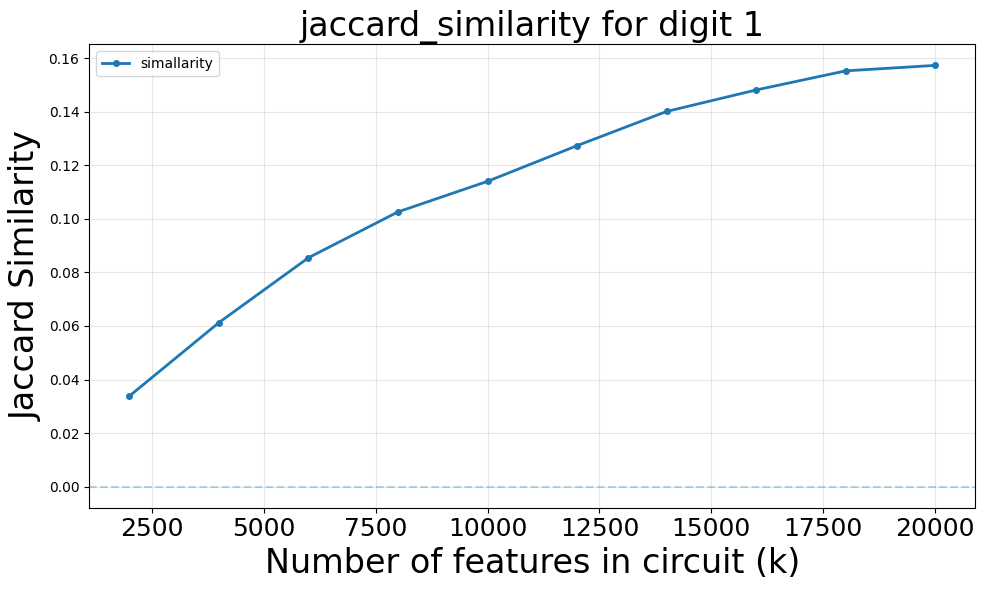

In [15]:
ys = [[jaccard_similarity(set(sorted_feats_cot[:k]), sorted_feats_reg) for k in test_k_values_cot]]
plot_series(test_k_values_cot ,ys, ["simallarity"], f"jaccard_similarity for digit {digit}" )

In [16]:
def plot_diffs_for_all_digits():
  for digit in [0,1,2]:
    sorted_feats_reg = sorted(feature_to_effect_reg[digit],
                            key=lambda k: abs(feature_to_effect_reg[digit][k]),
                          reverse=True)
    total_feats_reg = len(sorted_feats_reg)
    sorted_feats_cot = sorted(feature_to_effect_cot[digit],
                            key=lambda k: abs(feature_to_effect_cot[digit][k]),
                          reverse=True)
    total_feats_cot = len(sorted_feats_cot)
    test_k_values_cot = [int(total_feats_cot * i / 10) for i in range(1, 11)]  # 10%, 20%, ..., 100%
    test_k_values_cot = [max(1, k) for k in test_k_values_cot]  # Ensure all >= 1
    ys = [[jaccard_similarity(set(sorted_feats_cot[:k]), sorted_feats_reg) for k in test_k_values_cot]]

    sorted_feats_reg = sorted(feature_counter_reg[digit],
                            key=lambda k: abs(feature_counter_reg[digit][k]),
                          reverse=True)
    sorted_feats_cot = sorted(feature_counter_cot[digit],
                          key=lambda k: abs(feature_counter_cot[digit][k]),
                        reverse=True)
    ys.append([jaccard_similarity(set(sorted_feats_cot[:k]), sorted_feats_reg) for k in test_k_values_cot])


    plot_series(test_k_values_cot ,ys, ["full method", "attrbution_graphs_only"], f"jaccard_similarity for digit {digit}" )

In [24]:
def plot_diffs_for_all_digits():

  sorted_feats_cot = sorted(feature_to_effect_cot[digit],
                          key=lambda k: abs(feature_to_effect_cot[digit][k]),
                        reverse=True)
  total_feats_cot = len(sorted_feats_cot)
  test_k_values_cot = [int(total_feats_cot * i / 10) for i in range(1, 11)]  # 10%, 20%, ..., 100%
  test_k_values_cot = [max(1, k) for k in test_k_values_cot]  # Ensure all >= 1

  ys = [[jaccard_similarity(set(get_top_k_in_union(feature_to_effect_cot, k)), set(get_top_k_in_union(feature_to_effect_reg, k))) for k in test_k_values_cot]]
  ys.append([jaccard_similarity(set(get_top_k_in_union(feature_counter_cot, k)), set(get_top_k_in_union(feature_counter_reg, k))) for k in test_k_values_cot])
  plot_series(test_k_values_cot ,ys, ["Full Method", "Partial Method (Including Parts 1 & 2)"], f"Jaccard Similarity of Addition Circuits \n and Chain-of-Thought Addition Circuits by Circuit Sizes" )

In [ ]:
!pwd

/content


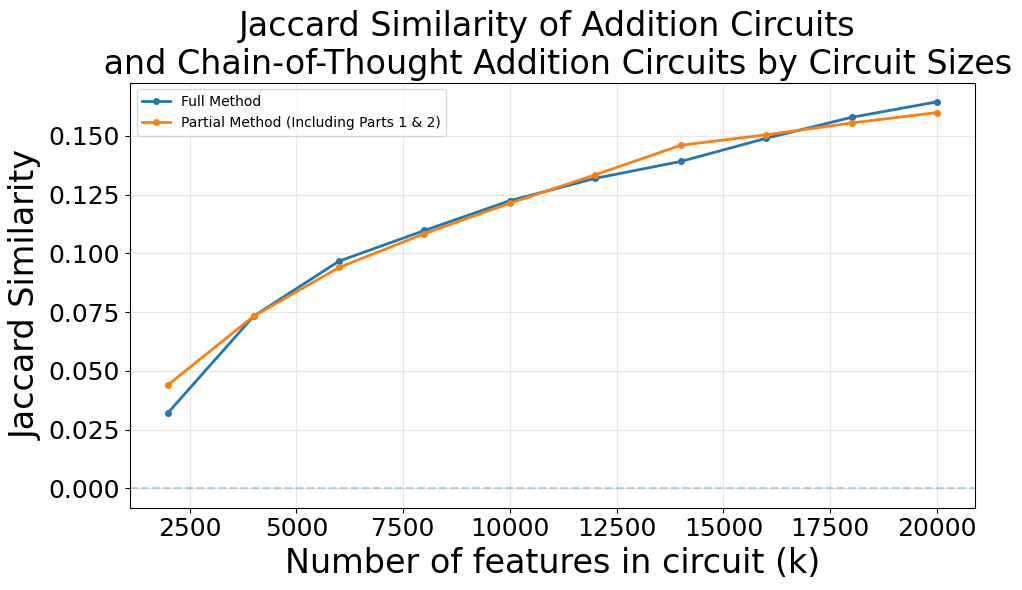

In [25]:
plot_diffs_for_all_digits()

In [ ]:
digit = 1
sorted_feats_reg = sorted(feature_to_effect_reg[digit],
                        key=lambda k: abs(feature_to_effect_reg[digit][k]),
                      reverse=True)
sorted_feats_cot = sorted(feature_to_effect_cot[digit],
                        key=lambda k: abs(feature_to_effect_cot[digit][k]),
                      reverse=True)

NUM_LAYERS = 26

def get_layers_sets(sorted_feats):
  layer_sets = [set() for _ in range(NUM_LAYERS)]
  for l,f in sorted_feats[:8000]:
    layer_sets[l].add(f)
  return layer_sets




In [ ]:
def plot_diffs_for_all_digits(k):
  for digit in [0,1,2]:
    sorted_feats_reg = sorted(feature_to_effect_reg[digit],
                            key=lambda k: abs(feature_to_effect_reg[digit][k]),
                          reverse=True)
    reg_layer_sets = get_layers_sets(sorted_feats_reg[:k])
    sorted_feats_cot = sorted(feature_to_effect_cot[digit],
                            key=lambda k: abs(feature_to_effect_cot[digit][k]),
                          reverse=True)
    cot_layer_sets = get_layers_sets(sorted_feats_cot[:k])
    ys = [[jaccard_similarity(cot, reg) for cot, reg in zip(cot_layer_sets, reg_layer_sets)]]
    plot_series(list(range(NUM_LAYERS)) ,ys, ["simallarity"], f"jaccard_similarity for digit {digit} by layers" )

# similarity of features by layer in model
 (not included in final report due to space problems)

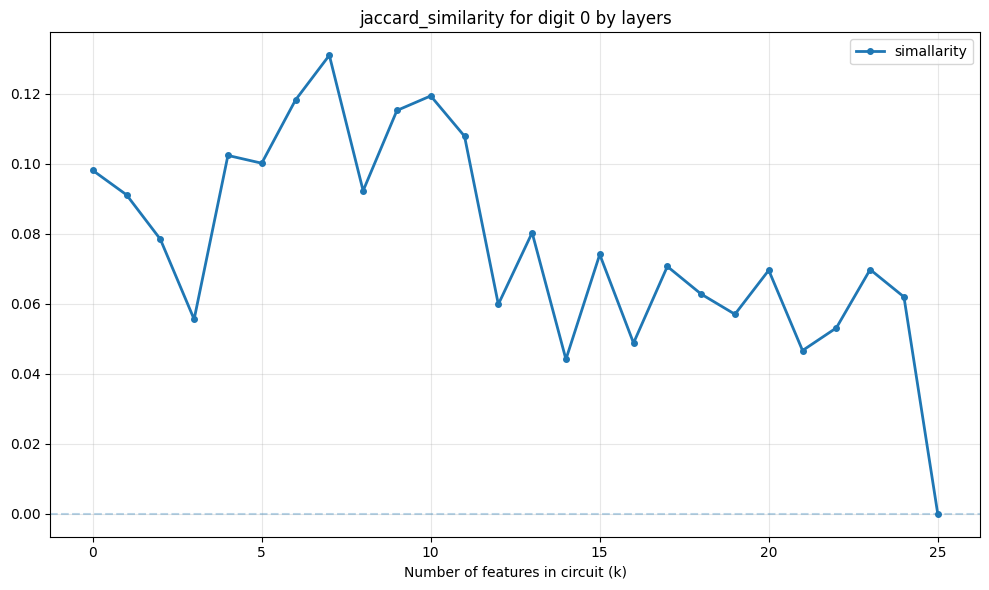

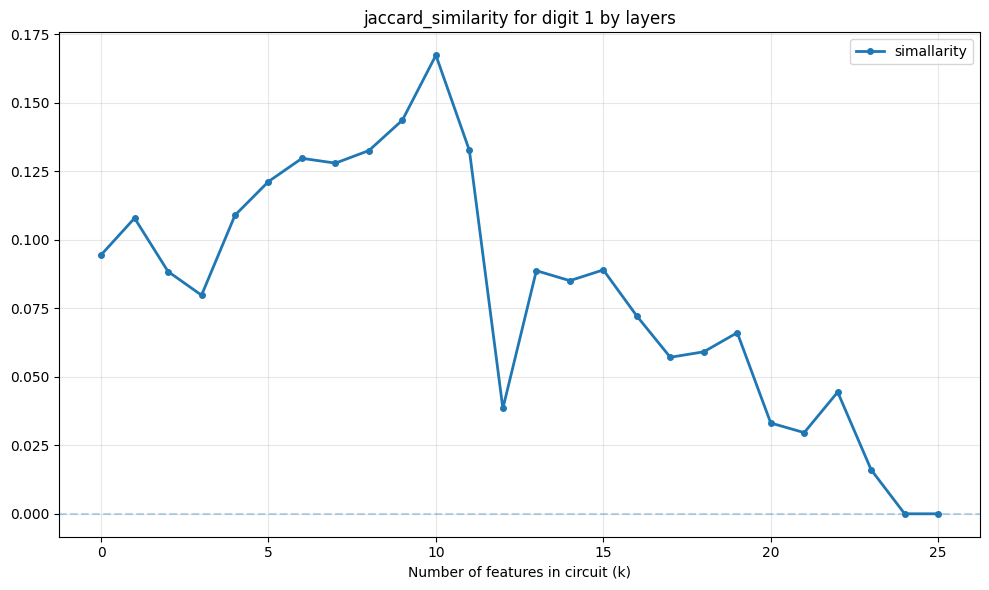

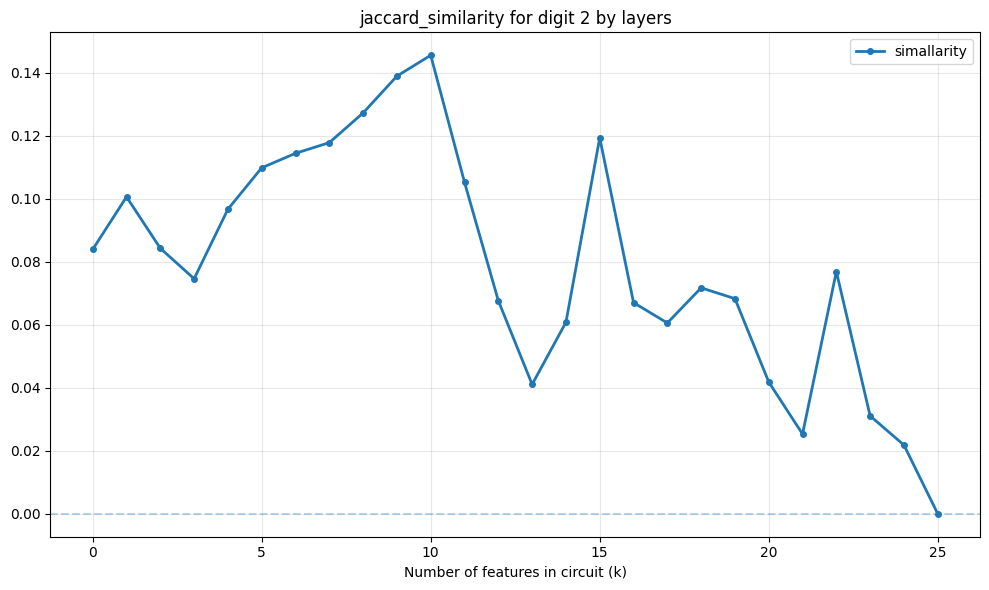

In [ ]:
plot_diffs_for_all_digits(8000)

In [ ]:
def plot_diffs_for_all_digits(k):
  cot_cicut = set()
  reg_circuit = set()
  for digit in [0,1,2]:
    reg_circuit.update(sorted(feature_to_effect_reg[digit],
                            key=lambda k: abs(feature_to_effect_reg[digit][k]),
                          reverse=True)[:k])
    cot_cicut.update(sorted(feature_to_effect_cot[digit],
                            key=lambda k: abs(feature_to_effect_cot[digit][k]),
                          reverse=True)[:k])

  reg_layer_sets = get_layers_sets(list(reg_circuit))
  cot_layer_sets = get_layers_sets(list(cot_cicut))
  ys = [[jaccard_similarity(cot, reg) for cot, reg in zip(cot_layer_sets, reg_layer_sets)]]
  plot_series(list(range(NUM_LAYERS)) ,ys, ["simallarity"], f"jaccard_similarity fo union by layers" )

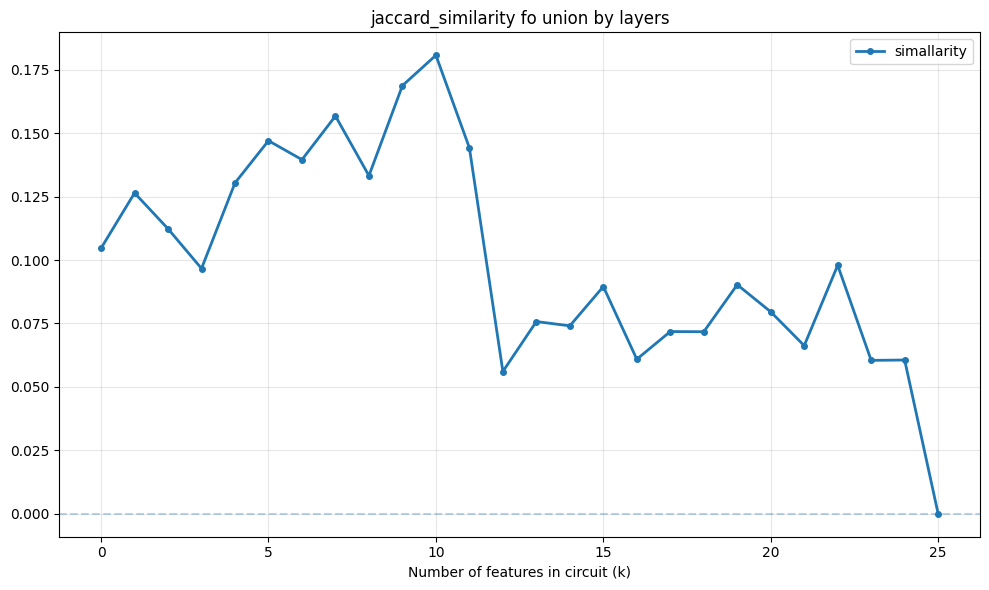

In [ ]:
plot_diffs_for_all_digits(8000)

#Get other circuts

In [ ]:
import gc
from collections import Counter
import torch
import numpy as np

# generate graphs for all  promts and count features
def get_feature_counts(prompts, model, max_n_logits,
                       desired_logit_prob, batch_size, max_feature_nodes):
  # Store graphs and their feature sets
  #feature_sets = [[], [], []]
  #features_with_pos = []
  # Count frequency of each active feature across graphs
  feature_counter = Counter()

  # Generate graphs
  for i, prompt in enumerate(prompts):
    print(f"graph number {i}")
    topic, digit_prompt, start_token = prompt
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    graph = attribute(
        prompt=digit_prompt,
        model=model,
        max_n_logits=max_n_logits,
        desired_logit_prob=desired_logit_prob,
        batch_size=batch_size,
        max_feature_nodes=max_feature_nodes,
        offload=None,
        verbose=False
    )
    save_data(f"/content/drive/MyDrive/graphs_{i}_{topic}_{file_extension}.pkl", graph)
    features_tensor = graph.active_features
    features_set = set([tuple([row.tolist()[0], row.tolist()[2]]) for row in features_tensor if row.tolist()[1] >= start_token + digit ])
    feature_counter.update(features_set)
  return feature_counter

In [ ]:
def get_top_features_by_count(feature_counter_, top_n=25000):
  # Sort features by count in descending order
  sorted_features = sorted(feature_counter_.items(), key=lambda item: item[1], reverse=True)

  # Take the top N items (keys and values)
  top_n_features_with_counts = sorted_features[:top_n]

  # Return only the feature names (keys)
  top_features = [feat[0] for feat in top_n_features_with_counts]

  print(f"Top {len(top_features)} active features.")


  return top_features

In [ ]:
Feature = namedtuple('Feature', ['layer', 'pos', 'feature_idx'])

def chattify(inputs:Union[str, List[str]], generate:bool=False):
    if isinstance(inputs, str):
        inputs = [inputs]
    input_list = []
    for i, s in enumerate(inputs):
        role = 'user' if i % 2 == 0 else 'assistant'
        input_list.append({'role': role, 'content':s})
    chattified = model.tokenizer.apply_chat_template(input_list, tokenize=False, add_generation_prompt=role!='assistant')
    if role == 'assistant':
        chattified = chattified[:-14]
    if not generate:
        # remove bos
        chattified =  chattified[5:]
    return chattified

## Additional Partial method Circuts

In [ ]:
import random
def generate_addition_prompts(count, seed = 22):
    random.seed(seed)
    results = []
    cot_prompts = []
    while(len(results) != count):
      result = random.randint(101, 197)
      max_num1 = result - 10
      num1 = random.randint(10, min(99, max_num1))
      num2 = result - num1
      prompt = chattify(f"ANSWER ONLY WITH THE RESULT, NO SPACES. {num1:02d}+{num2:02d}=")
      cot_prompt = f"provide a step-by-step calculation where each digit is added separately including any necessary carrying {num1:02d}+{num2:02d}="
      check, new_cot_prompt = check_prompt(prompt, cot_prompt, result)
      if check:
        results.append((prompt, result))
        cot_prompts.append((new_cot_prompt, result))
    return results, cot_prompts

In [ ]:
import random
def generate_subtraction_prompts(count, seed = 22):
    random.seed(seed)
    prompts = []
    while(len(prompts) != count):
      num1 = random.randint(50, 99)
      num2 = random.randint(10, 50)
      prompt = chattify(f"ANSWER ONLY WITH THE RESULT, NO SPACES. {num1:02d}-{num2:02d}=")
      prompts.append(prompt)
    return prompts

start_token = model.get_token_position("9",'<start_of_turn>user\nANSWER ONLY WITH THE RESULT, NO SPACES. 9<end_of_turn>\n<start_of_turn>model\n')

subtraction_topic = [("subtraction", p, start_token) for p in generate_subtraction_prompts(30)]

In [ ]:
import random
def generate_subtraction_prompts_COT(count, seed = 22):
    random.seed(seed)
    prompts = []
    while(len(prompts) != count):
      num1 = random.randint(50, 99)
      num2 = random.randint(10, 50)
      prompt = chattify(f"provide a step-by-step calculation where each digit is subtracted separately including any necessary carrying {num1:02d}-{num2:02d}=")
      prompts.append(prompt)
    return prompts

start_token = model.get_token_position("6",'<start_of_turn>user\nprovide a step-by-step calculation where each digit is subtracted separately including any necessary carrying 6<end_of_turn>\n<start_of_turn>model\n')

subtraction_cot_topic = [("step_by_step_subtraction", p, start_token) for p in generate_subtraction_prompts_COT(30)]

In [ ]:

prompts_flowers = [
"How many leaves does the Rose flower usually have?",
"In how many seasons does the Mango tree appear with fruits?",
"How many petals and leaves does the Tulip flower contain?",
"During how many months of the year does the Cherry Blossom tree appear in bloom?",
"How many leaves are normally found on a Sunflower plant?",
"In how many different seasons does the Olive tree grow new leaves?",
"How many green leaves are attached to a single Lily flower stem?",
"In how many seasons does the Apple tree appear with blossoms?",
"How many small leaves does the Jasmine flower branch carry?",
"In how many seasons of the year does the Pine tree stay green with its leaves?",
"How many leaves are on a typical Daffodil stem?",
"In how many seasons does the Orange tree produce flowers?",
"How many petals are there in a Marigold flower?",
"In how many months does the Almond tree stay in bloom?",
"How many leaves are attached to a Hibiscus flower branch?",
"In how many seasons does the Grapevine produce fruit?",
"How many petals does a Poppy flower usually have?",
"In how many months of the year does the Lotus flower bloom?",
"How many leaves does the Carnation flower normally carry?",
"In how many seasons does the Pear tree appear with blossoms?",
"How many petals are there in a Daisy flower?",
"In how many months does the Plum tree stay in bloom?",
"How many leaves can be counted on a Chrysanthemum stem?",
"In how many different seasons does the Fig tree produce fruit?",
"How many petals are found on a Magnolia flower?",
"In how many seasons does the Banana tree produce leaves?",
"How many leaves are present on a Snapdragon flower stem?",
"In how many months of the year does the Peach tree flower?",
"How many petals does a Camellia flower contain?",
"In how many seasons does the Walnut tree produce fruit?"
]

start_token = model.get_token_position("How",'<start_of_turn>user\nHow many leaves does the Rose flower usually have?<end_of_turn>\n<start_of_turn>model\n')

prompts_flowers_topic = [("flowers", p, start_token) for p in prompts_flowers]

In [ ]:
prompts_flowers_step_by_step = [
"think step by step How many leaves does the Rose flower usually have?",
"think step by step In how many seasons does the Mango tree appear with fruits?",
"think step by step How many petals and leaves does the Tulip flower contain?",
"think step by step During how many months of the year does the Cherry Blossom tree appear in bloom?",
"think step by step How many leaves are normally found on a Sunflower plant?",
"think step by step In how many different seasons does the Olive tree grow new leaves?",
"think step by step How many green leaves are attached to a single Lily flower stem?",
"think step by step In how many seasons does the Apple tree appear with blossoms?",
"think step by step How many small leaves does the Jasmine flower branch carry?",
"think step by step In how many seasons of the year does the Pine tree stay green with its leaves?",
"think step by step How many leaves are on a typical Daffodil stem?",
"think step by step In how many seasons does the Orange tree produce flowers?",
"think step by step How many petals are there in a Marigold flower?",
"think step by step In how many months does the Almond tree stay in bloom?",
"think step by step How many leaves are attached to a Hibiscus flower branch?",
"think step by step In how many seasons does the Grapevine produce fruit?",
"think step by step How many petals does a Poppy flower usually have?",
"think step by step In how many months of the year does the Lotus flower bloom?",
"think step by step How many leaves does the Carnation flower normally carry?",
"think step by step In how many seasons does the Pear tree appear with blossoms?",
"think step by step How many petals are there in a Daisy flower?",
"think step by step In how many months does the Plum tree stay in bloom?",
"think step by step How many leaves can be counted on a Chrysanthemum stem?",
"think step by step In how many different seasons does the Fig tree produce fruit?",
"think step by step How many petals are found on a Magnolia flower?",
"think step by step In how many seasons does the Banana tree produce leaves?",
"think step by step How many leaves are present on a Snapdragon flower stem?",
"think step by step In how many months of the year does the Peach tree flower?",
"think step by step How many petals does a Camellia flower contain?",
"think step by step In how many seasons does the Walnut tree produce fruit?"
]
start_token = model.get_token_position("5",'<start_of_turn>user\nthink step by step 5 many leaves does the Rose flower usually have?<end_of_turn>\n<start_of_turn>model\n')

prompts_flowers_step_by_step_topic = [("step_by_step_flowers", p, start_token) for p in prompts_flowers_step_by_step]

In [ ]:
addition_in_words = [
"ADD TEN TO FIVE",
"ADD TWENTY TO FORTY",
"ADD FIFTY TO TEN",
"ADD SEVENTY TO THIRTY",
"ADD NINETY TO NINE",
"ADD SIXTY TO FIFTY",
"ADD ELEVEN TO FOUR",
"ADD TWELVE TO TWENTY",
"ADD EIGHTY TO TWENTY",
"ADD ONE HUNDRED TO FIFTY",
"ADD THIRTEEN TO SEVEN",
"ADD FOURTEEN TO SIX",
"ADD FIFTEEN TO FIFTEEN",
"ADD SIXTEEN TO EIGHT",
"ADD SEVENTEEN TO TEN",
"ADD EIGHTEEN TO TWELVE",
"ADD NINETEEN TO ELEVEN",
"ADD TWENTY ONE TO NINE",
"ADD TWENTY TWO TO TWENTY TWO",
"ADD TWENTY FIVE TO FIVE",
"ADD THIRTY TO THIRTY",
"ADD THIRTY FIVE TO TWENTY",
"ADD FORTY TO SIXTY",
"ADD FORTY FIVE TO TEN",
"ADD FIFTY FIVE TO FORTY FIVE",
"ADD SIXTY FIVE TO THIRTY FIVE",
"ADD SEVENTY FIVE TO TWENTY FIVE",
"ADD EIGHTY FIVE TO FIFTEEN",
"ADD NINETY FIVE TO FIVE",
"ADD ONE HUNDRED TO ONE HUNDRED"
]

start_token = model.get_token_position("ADD",'<start_of_turn>user\nADD NINETY TO NINE<end_of_turn>\n<start_of_turn>model\n')

addition_in_words_topic = [("word_addtition", p, start_token) for p in addition_in_words]

In [ ]:
addition_in_words_cot = [
"think step by step ADD TEN TO FIVE",
"think step by step ADD TWENTY TO FORTY",
"think step by step ADD FIFTY TO TEN",
"think step by step ADD SEVENTY TO THIRTY",
"think step by step ADD NINETY TO NINE",
"think step by step ADD SIXTY TO FIFTY",
"think step by step ADD ELEVEN TO FOUR",
"think step by step ADD TWELVE TO TWENTY",
"think step by step ADD EIGHTY TO TWENTY",
"think step by step ADD ONE HUNDRED TO FIFTY",
"think step by step ADD THIRTEEN TO SEVEN",
"think step by step ADD FOURTEEN TO SIX",
"think step by step ADD FIFTEEN TO FIFTEEN",
"think step by step ADD SIXTEEN TO EIGHT",
"think step by step ADD SEVENTEEN TO TEN",
"think step by step ADD EIGHTEEN TO TWELVE",
"think step by step ADD NINETEEN TO ELEVEN",
"think step by step ADD TWENTY ONE TO NINE",
"think step by step ADD TWENTY TWO TO TWENTY TWO",
"think step by step ADD TWENTY FIVE TO FIVE",
"think step by step ADD THIRTY TO THIRTY",
"think step by step ADD THIRTY FIVE TO TWENTY",
"think step by step ADD FORTY TO SIXTY",
"think step by step ADD FORTY FIVE TO TEN",
"think step by step ADD FIFTY FIVE TO FORTY FIVE",
"think step by step ADD SIXTY FIVE TO THIRTY FIVE",
"think step by step ADD SEVENTY FIVE TO TWENTY FIVE",
"think step by step ADD EIGHTY FIVE TO FIFTEEN",
"think step by step ADD NINETY FIVE TO FIVE",
"think step by step ADD ONE HUNDRED TO ONE HUNDRED"
]
start_token = model.get_token_position("8",'<start_of_turn>user\nthink step by step 8 NINETY TO NINE<end_of_turn>\n<start_of_turn>model\n')

addition_in_words_cot_topic = [("step_by_step_word_addtition", p, start_token) for p in addition_in_words_cot]

In [ ]:
# list of topics: inlcuding( "topic", "prompt", strat_token)
topics = [addition_in_words_cot_topic , prompts_flowers_step_by_step_topic,prompts_flowers_topic, addition_in_words_topic , subtraction_topic , subtraction_cot_topic]

In [ ]:
def save_data(path, features):
    """Save trimmed_feature_dict and prompts_and_results to a file."""
    with open(path, 'wb') as f:
        pickle.dump((features), f)
def load_data(path):
    """Load trimmed_feature_dict and prompts_and_results from a file."""
    with open(path, 'rb') as f:
        return pickle.load(f)  # returns (trimmed_feature_dict, prompts_and_results)


In [ ]:
max_n_logits = 10
desired_logit_prob = 0.95
batch_size = 254
max_feature_nodes = 8192
for topic in topics:
  topic_name = topic[0][0]
  print(topic_name)
  feature_counter = get_feature_counts(topic, model,
                                                                max_n_logits, desired_logit_prob, batch_size, max_feature_nodes)
  most_common_features = get_top_features_by_count(feature_counter, top_n=8000)
  save_data(f"/content/drive/MyDrive/feature_counter_{topic_name}.pkl", feature_counter)
  save_data(f"/content/drive/MyDrive/most_common_features{topic_name}.pkl", most_common_features)


In [ ]:
topic_names = set([ t[0][0] for t in topics])

In [ ]:
topic_names

{'flowers',
 'step_by_step_flowers',
 'step_by_step_subtraction',
 'step_by_step_word_addtition',
 'subtraction',
 'word_addtition'}

In [ ]:
topic_features = {}
for topic_name in topic_names:
  topic_features[topic_name] = load_data(f"/content/drive/MyDrive/most_common_features{topic_name}.pkl")
topic_features["addition"] = get_top_k_in_union(feature_to_effect_reg, 8000)
topic_features["step_by_step_addition"] = get_top_k_in_union(feature_to_effect_cot, 8000)

In [ ]:
topic_features["addition_partial"] = get_top_k_in_union(feature_counter_reg, 8000)
topic_features["step_by_step_addition_partial"] = get_top_k_in_union(feature_counter_cot, 8000)

In [ ]:
comparions = [
    ("flowers", "step_by_step_flowers"),
    ("subtraction", "step_by_step_subtraction"),
    ("word_addtition", "step_by_step_word_addtition"),
    ("addition", "step_by_step_addition"),

    ("subtraction", "addition"),
    ("flowers", "addition"),
    ("word_addtition", "addition"),

    ("step_by_step_addition", "step_by_step_flowers"),
    ("step_by_step_addition", "step_by_step_word_addtition"),
    ("step_by_step_addition", "step_by_step_subtraction"),

    ]

In [ ]:
def plot_diffs(comparions, topic_features):
  ys = []
  lables = []
  for c1, c2 in comparions:
    c1_sets = set(topic_features[c1])
    c2_sets = set(topic_features[c2])
    ys.append([jaccard_similarity(c1_sets, c2_sets)])
    print(f"{c1} vs {c2}")
    print(jaccard_similarity(c1_sets, c2_sets))
    lables.append(f"{c1} vs {c2}")
  plot_series([1] ,ys, lables, f"jaccard_similarity fo union by layers" )

# Similarity resutls

flowers vs step_by_step_flowers
0.7193208682570384
subtraction vs step_by_step_subtraction
0.37800361725949533
word_addtition vs step_by_step_word_addtition
0.5761993892227367
addition vs step_by_step_addition
0.10972395616590373
subtraction vs addition
0.3105086411663527
flowers vs addition
0.06312292358803986
word_addtition vs addition
0.1671164928149391
step_by_step_addition vs step_by_step_flowers
0.055548225359546115
step_by_step_addition vs step_by_step_word_addtition
0.0738255033557047
step_by_step_addition vs step_by_step_subtraction
0.14114542472006275


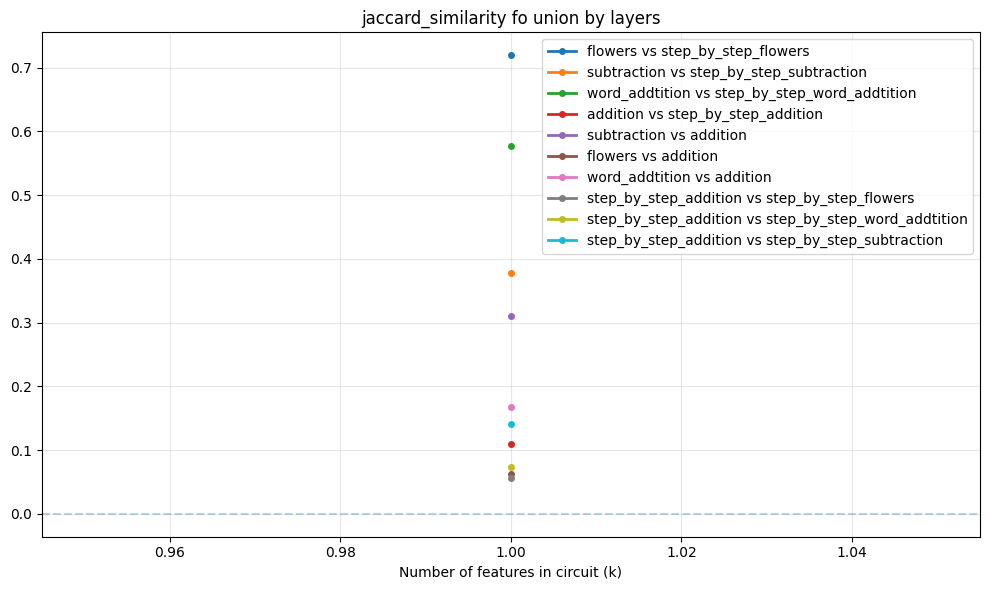

In [ ]:
plot_diffs(comparions,topic_features)

In [ ]:
from matplotlib import pyplot as plt
def plot_series(x, ys, labels, title):
    plt.figure(figsize=(10, 6))
    for y, lab in zip(ys, labels):
        plt.plot(x, y, marker='o', linewidth=2, markersize=4, label=lab)
    plt.legend()
    plt.xlabel("Number of features in circuit (k)")
    plt.grid(True, alpha=0.3); plt.axhline(y=0, linestyle='--', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()